In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Define hyperparameters
EPOCHS = 50
BATCH_SIZE = 512
noise_dim = 100
num_examples_to_generate = 16

In [16]:

# Load the MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
#train_dataset, validation_dataset, test_dataset = keras.datasets.celeba.load_data()


# Normalize the pixel values to be between -1 and 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

# Create a tf.data.Dataset object for the MNIST dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)


In [17]:
# Create the generator models

def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


In [18]:
# Create the discriminator models

def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss functions for the generator and discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the optimizers for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [21]:
# Define the training loop
def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #calculate deriviteve
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #update weight using calculation of derivitive

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print("gen_loss" , np.mean(gen_loss))
        print("disc_loss" , np.mean(disc_loss))
        #print("gen_loss" , gen_loss)


In [22]:
# Train the GAN model
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)

In [23]:
# Train the GAN model
train(dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
gen_loss 1.0633113
disc_loss 1.0184492
gen_loss 1.078758
disc_loss 1.0221502
gen_loss 1.1360486
disc_loss 0.998623
gen_loss 1.2182026
disc_loss 0.9853765
gen_loss 1.2682599
disc_loss 0.984452
gen_loss 1.2200116
disc_loss 0.9696169
gen_loss 1.1709901
disc_loss 0.9409282
gen_loss 1.1306257
disc_loss 0.96612453
gen_loss 1.122399
disc_loss 1.0055343
gen_loss 1.1656845
disc_loss 0.9865791
gen_loss 1.1588955
disc_loss 1.0231247
gen_loss 1.155064
disc_loss 1.0108302
gen_loss 1.1453004
disc_loss 1.0492122
gen_loss 1.128072
disc_loss 1.0208135
gen_loss 1.1043282
disc_loss 1.0190313
gen_loss 1.1055499
disc_loss 1.0347795
gen_loss 1.1338373
disc_loss 1.041224
gen_loss 1.1088076
disc_loss 1.0231915
gen_loss 1.1336346
disc_loss 0.98960733
gen_loss 1.1493704
disc_loss 1.0468965
gen_loss 1.1787627
disc_loss 1.0403502
gen_loss 1.1254764
disc_loss 1.0236458
gen_loss 1.1194767
disc_loss 1.1043546
gen_loss 1.0489368
disc_loss 1.1058968
gen_loss 1.0013855

In [24]:
a = np.random.randn(2,100)
a.shape

(2, 100)

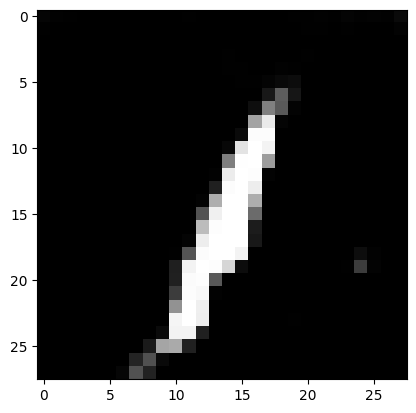

In [25]:
import cv2
img = generator(np.random.randn(1,100))
img = np.reshape(img,(28,28))
plt.imshow(img,cmap='gray')


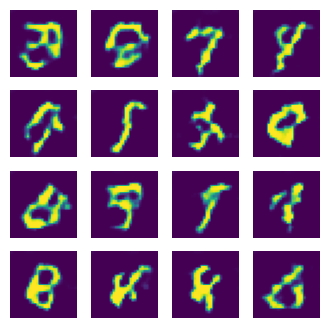

In [26]:
# Save the generator weights to a file
generator.save_weights('generator_weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()